This script contains code that computes a rough thalweg through Puget Sound and saves it as a text file. The thalweg that it computes is very rough and should not be thought of as an adequate thalweg estimation. 

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as NC
import numpy as np
import itertools
import numpy as np
import os
import pandas as pd
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm


The following function will compute the grid points of the thalweg beginning at (ist,jst) and ending at ijend. The thalweg is the path that follows the maximum depth through the Strait. This function works by finding the maximum depth in a neighbourhood of (ist, jst) and then iterating through i or j (set by the direction flag) and terminates when the iteration reches ijend. At each iteration it records the location of the maximum depth in a neighbourhood of (i,j). The size of the neighbourhood is set by thres.

The resulting thalweg is a little bit choppy. This function must be applied several times to sections of the Strait. 

In [3]:
def find_thalweg(bathy,ist,jst,direction,ijend,thres):
    #Starting at (ist,jst) this function computes the gridpoints of thalweg by iterating through points until ijend.
    #At each iteration it calculates the maximum depth in a neighborhood of (i,j)
    #bathy: an array of the bathymetry
    #ist: an int that defines the starting i grid point
    #jst: an int that defines the starting j grid point
    #direction: a string either 'i' or 'j' indicating the direction of the iterations
    #thres: an int defining the size of the neighbourhood.
    
    #returns thalweg: an array contatining the [j,i] thalweg gridpoints.
    
    if direction == 'i':
    
        #thres defines the search distance in the i-direction.
        if ist<ijend:
            thalweg=np.zeros((ijend-ist,2))
            loop_start=ist+1; loop_end=ijend
            forward=1; backward=0
        else:
            thalweg=np.zeros((ist-ijend,2)) 
            loop_start=0; loop_end=ist-ijend-1;
            forward=0; backward=1;
    
        #find index of first maximum
        bathmax=bathy[jst-thres:jst+thres,ist].max(); 
        ind= np.where(bathy[:,ist]==bathmax)
        ls=0
        while ind[0][ls]< jst-thres:
            ls=ls+1
        j=ind[0][ls]
        arr_ind=0*forward + (ist-ijend-1)*backward;  
        thalweg[arr_ind,0]=j
        thalweg[arr_ind,1]=ist

        #for loop for finding the thalweg
        for k in range (loop_start,loop_end):
            loop_ind = k*forward + (ist-k)*backward;
            bathmax=bathy[j-thres:j+thres,loop_ind].max();
            ind= np.where(bathy[:,loop_ind]==bathmax)
            ls=0
            while ind[0][ls]< j-thres:
                ls=ls+1
            j=ind[0][ls]
            arr_ind=(k-ist)*forward + (loop_end-k-1)*backward;  
            thalweg[arr_ind,0]=j
            thalweg[arr_ind,1]=loop_ind;
            
    elif direction == 'j':
    
        #thres defines the search distance in the j-direction.
        if jst<ijend:
            thalweg=np.zeros((ijend-jst,2))
            loop_start=jst+1; loop_end=ijend
            forward=1; backward=0
        else:
            thalweg=np.zeros((jst-ijend,2)) 
            loop_start=0; loop_end=jst-ijend-1;
            forward=0; backward=1;
    
        #find index of first maximum
        bathmax=bathy[jst,ist-thres:ist+thres].max(); 
        ind= np.where(bathy[jst,:]==bathmax)
        ls=0
        while ind[0][ls]< ist-thres:
            ls=ls+1
        i=ind[0][ls]
        arr_ind=0*forward + (jst-ijend-1)*backward;  
        thalweg[arr_ind,0]=jst
        thalweg[arr_ind,1]=i

        #for loop for finding the thalweg
        for k in range (loop_start,loop_end):
            loop_ind = k*forward + (jst-k)*backward;
            bathmax=bathy[loop_ind,i-thres:i+thres].max();
            ind= np.where(bathy[loop_ind,:]==bathmax)
            ls=0
            while ind[0][ls]< i-thres:
                ls=ls+1
            i=ind[0][ls]
            arr_ind=(k-jst)*forward + (loop_end-k-1)*backward;  
            thalweg[arr_ind,0]=loop_ind
            thalweg[arr_ind,1]=i;
            
    else:
        return 'Error'
    
    return thalweg

In [4]:
def remove_section(thalweg, start, end, direction):
    #This function is used to remove a jagged section of the thalweg and replace it with a straight line.
    #thalweg: an array containing the thalweg grid coordinates
    #start: an int containing the i or j coordintate where the cut begins
    #end: an int contatining the i o j coordinate where the cut ends
    #direction: indicates where start and end represent an i or j coordinate.

    if direction == 'j':
        flag1=0; flag2=1
    elif direction == 'i':
        flag1=1; flag2=0
    else:
        return 'Error'
        
    #find index of cut points in other coordinate
    index= np.where(thalweg[:,flag1]==start); index_st=index[0][0]
    index= np.where(thalweg[:,flag1]==end); index_end=index[0][0]

    #start and end points of
    start2=thalweg[index_st,flag2]; end2=thalweg[index_end,flag2]; 
    #draw a straight line to connect (start,start2) to (end,end2)
    newinds = start2 + (end2-start2)/(end-start)*(thalweg[index_st:index_end,flag1]-start)
    newinds=np.rint(newinds)
    #replace the thalwegs with newinds
    thalweg_copy=thalweg
    thalweg_copy[index_st:index_end,flag2] = newinds
    
    return thalweg_copy

In [5]:
def distance(thalweg,dx,dy,reverse=False):
    #this function calculates the distance travelled along the thalweg
    #thalweg is the array of grid coordinates.
    #dx is the grid spacing in x (eventually we could send an array in but for now it is a single value).
    #dy is the grid spacing in y (eventually we could send an array in but for now it is a single value).
    
    leng=thalweg.shape
    l =leng[0]
    distance = np.zeros(l)
    d=0
    
    for k in range(1,l):
        i1=thalweg[k-1,1]; i2=thalweg[k,1];
        j1=thalweg[k-1,0]; j2=thalweg[k,0];
        dseg =( (dx*(i2-i1))**2 + (dy*(j2-j1))**2)**(0.5)
        d=d+dseg
        distance[k]=d;
    if reverse == True:
        distance=np.flip(distance)
    return distance

219 39
231 78
254 107


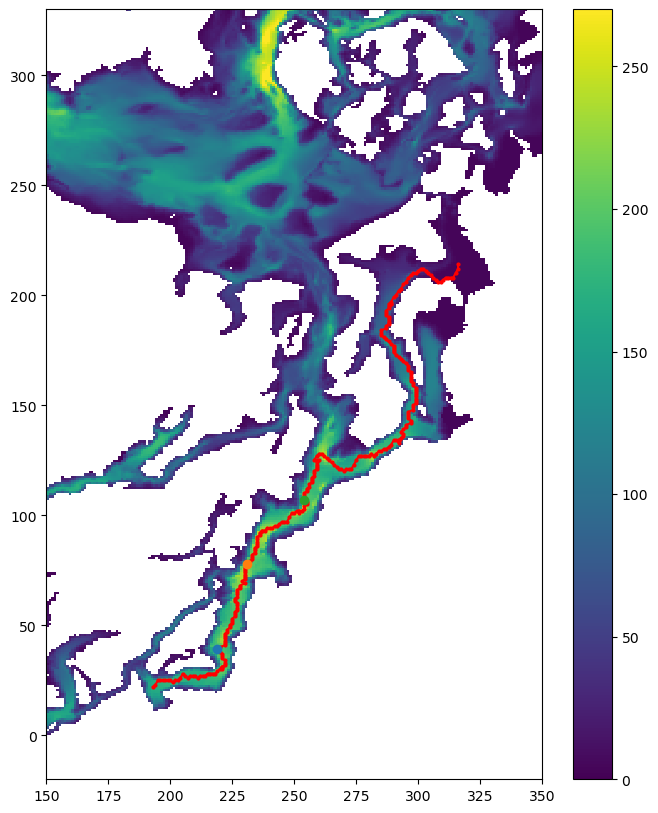

In [15]:
# This bathymetry data is in desperate need of updating. 
# test the function
#grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea.nc','r')
grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc','r')
bathy = grid.variables['Bathymetry'][:,:]

#masking
mu = bathy == 0
bathy_mask= np.ma.array(bathy,mask=mu)

#the thalweg is caclualted in sections:
#caculate first section of thalweg
step=2; ist=315; jst=215; ijend=285; direction='i';
thalweg6 = find_thalweg(bathy,ist,jst,direction,ijend,step)
#remove several jagged sections
#jstart=600; jend=645;
#thalweg5 = remove_section(thalweg5,jstart,jend,'j');
#jstart=425; jend=447;
#thalweg5 = remove_section(thalweg5,jstart,jend,'j');
#next section
jst=int(thalweg6[0,0]);  ist= int(thalweg6[0,1]); ijend=130; direction = 'j';
thalweg5 = find_thalweg(bathy,ist,jst,direction,ijend,step)
#next section 
jst=int(thalweg5[0,0]);  ist= int(thalweg5[0,1]); ijend=255; direction = 'i';
thalweg4 = find_thalweg(bathy,ist,jst,direction,ijend,step)
#next section
jst=int(thalweg4[0,0]);  ist= int(thalweg4[0,1]); ijend=98; direction = 'j';
thalweg3 = find_thalweg(bathy,ist,jst,direction,ijend,step)
#next section
jst=int(thalweg3[0,0]);  ist= int(thalweg3[0,1]); ijend=235; direction = 'i';
thalweg2 = find_thalweg(bathy,ist,jst,direction,ijend,step)
#next section
jst=int(thalweg2[0,0]);  ist= int(thalweg2[0,1]); ijend=27; direction='j';
thalweg1 = find_thalweg(bathy,ist,jst,direction,ijend,step)
#next section
jst=int(thalweg1[0,0]);  ist= int(thalweg1[0,1]); ijend=190; direction='i';
thalweg0 = find_thalweg(bathy,ist,jst,direction,ijend,step)


#Combine all together
Tjs = [thalweg0[:,0],thalweg1[:,0],thalweg2[:,0],thalweg3[:,0],thalweg4[:,0],thalweg5[:,0],thalweg6[:,0]];
Tjs =list(itertools.chain.from_iterable(Tjs)); Tjs=np.array(Tjs); 
Tis = [thalweg0[:,1],thalweg1[:,1],thalweg2[:,1],thalweg3[:,1],thalweg4[:,1],thalweg5[:,1],thalweg6[:,1]];
Tis =list(itertools.chain.from_iterable(Tis)); Tis=np.array(Tis); 

thalweg=[Tjs, Tis];  thalweg=list(zip(*thalweg)); thalweg=np.array(thalweg,'i'); 

fig,ax = plt.subplots(1,1,figsize=(8,10))
cmin=0; cmax=270;
ps=ax.pcolormesh(bathy,vmin=cmin,vmax=cmax,cmap='viridis') # This will have to be changed in orderto get a clearer view of the Puget thalweg.
fig.colorbar(ps)

ax.plot(thalweg[:,1]+1,thalweg[:,0]+1,marker='o',color='r',markersize=2)
ax.set_xlim(150,350)
ax.set_ylim(-20,330)

# for k in range (1,6):
#     pylab.plot(thalweg[k*39,1]+1, thalweg[k*39,0]+1,'o')
#     print(thalweg[k*39,1] + 1, thalweg[k*39,0] + 1)

k=1
pylab.plot(thalweg[k*39,1]+1, thalweg[k*39,0]+1,'o')
print(thalweg[k*39,1] + 1, thalweg[k*39,0] + 1)

k=2
pylab.plot(thalweg[k*39,1]+1, thalweg[k*39,0]+1,'o')
print(thalweg[k*39,1] + 1, thalweg[k*39,0] + 1)

k=3
pylab.plot(thalweg[k*39,1]+1, thalweg[k*39,0]+1,'o')
print(thalweg[k*39,1] + 1, thalweg[k*39,0] + 1)
# pylab.plot(34,204,'o')
#pylab.axis([240,300,300,400])

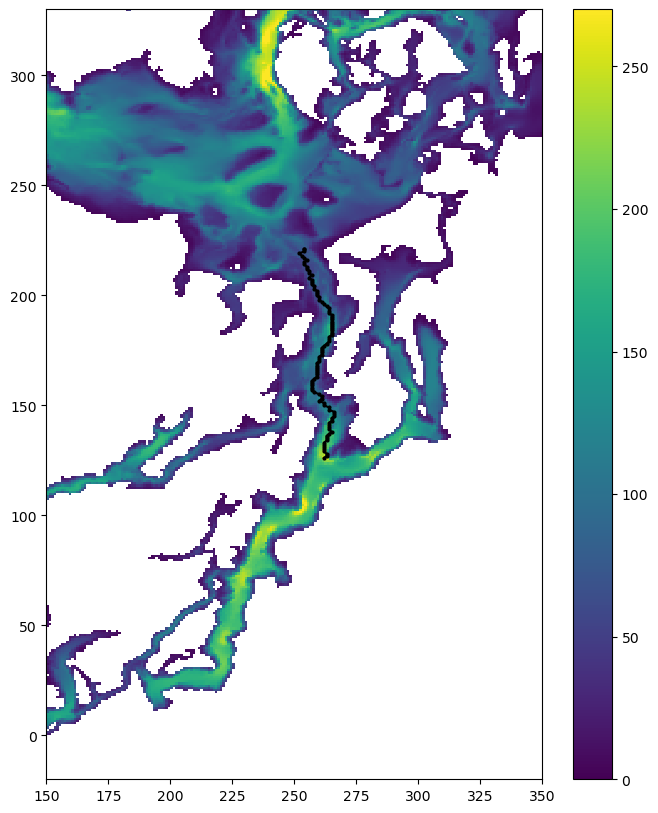

In [59]:
grid = NC.Dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc', 'r')
bathy = grid.variables['Bathymetry'][:,:]

#masking
mu = bathy == 0
bathy_mask= np.ma.array(bathy,mask=mu)

#Starting at (ist,jst) this function computes the gridpoints of thalweg by iterating through points until ijend.
#At each iteration it calculates the maximum depth in a neighborhood of (i,j)
#bathy: an array of the bathymetry
#ist: an int that defines the starting i grid point
#jst: an int that defines the starting j grid point
#direction: a string either 'i' or 'j' indicating the direction of the iterations
#thres: an int defining the size of the neighbourhood.
# step=2; ist=255; jst=220; iend=260; direction='j';
# thalweg_00 = find_thalweg(bathy,ist,jst,direction,ijend,step)

step=2; ist=260; jst=125; iend=250; direction='j';
thalweg_00 = find_thalweg(bathy,ist,jst,direction,ijend,step)

step=2; ist=255; jst=220; iend=255; direction='j';
thalweg_02 = find_thalweg(bathy,ist,jst,direction,ijend,step)

thalweg_01 = np.array([[190, 264],
                       [191, 263]])

#Combine all together
# Tjs = [thalweg0[:,0],thalweg1[:,0],thalweg2[:,0],thalweg3[:,0],thalweg4[:,0],thalweg5[:,0],thalweg6[:,0]];
# Tjs =list(itertools.chain.from_iterable(Tjs)); Tjs=np.array(Tjs); 
# Tis = [thalweg0[:,1],thalweg1[:,1],thalweg2[:,1],thalweg3[:,1],thalweg4[:,1],thalweg5[:,1],thalweg6[:,1]];
# Tis =list(itertools.chain.from_iterable(Tis)); Tis=np.array(Tis); 

# thalweg=[Tjs, Tis];  thalweg=list(zip(*thalweg)); thalweg=np.array(thalweg,'i'); 

Tjs = [thalweg_00[:,0],thalweg_01[:,0],thalweg_02[:,0]];
Tjs =list(itertools.chain.from_iterable(Tjs)); Tjs=np.array(Tjs); 
Tis = [thalweg_00[:,1],thalweg_01[:,1],thalweg_02[:,1]];
Tis =list(itertools.chain.from_iterable(Tis)); Tis=np.array(Tis); 

thalweg=[Tjs, Tis];  thalweg=list(zip(*thalweg)); thalweg=np.array(thalweg,'i'); 

fig,ax = plt.subplots(1,1,figsize=(8,10))
cmin=0; cmax=270;
ps=ax.pcolormesh(bathy,vmin=cmin,vmax=cmax,cmap='viridis') # This will have to be changed in orderto get a clearer view of the Puget thalweg.
fig.colorbar(ps)

# ax.plot(thalweg[:,1]+1,thalweg[:,0]+1,marker='o',color='r',markersize=2)
ax.set_xlim(150,350)
ax.set_ylim(-20,330)

ax.plot(thalweg_00[:,1]+1, thalweg_00[:,0]+1,marker='o',color='k',markersize=2)
ax.plot(thalweg_01[:,1]+1, thalweg_01[:,0]+1,marker='o',color='k',markersize=2)
ax.plot(thalweg_02[:,1]+1, thalweg_02[:,0]+1,marker='o',color='k',markersize=2)

# for k in range (1,6):
#     pylab.plot(thalweg[k*39,1]+1, thalweg[k*39,0]+1,'o')
#     print(thalweg[k*39,1] + 1, thalweg[k*39,0] + 1)

In [60]:
with open('admiralty_thalweg.txt','w') as pt:
    np.savetxt(pt,np.flip(thalweg,0),fmt='%i')
pt.close()

Text(0, 0.5, ' z (m)')

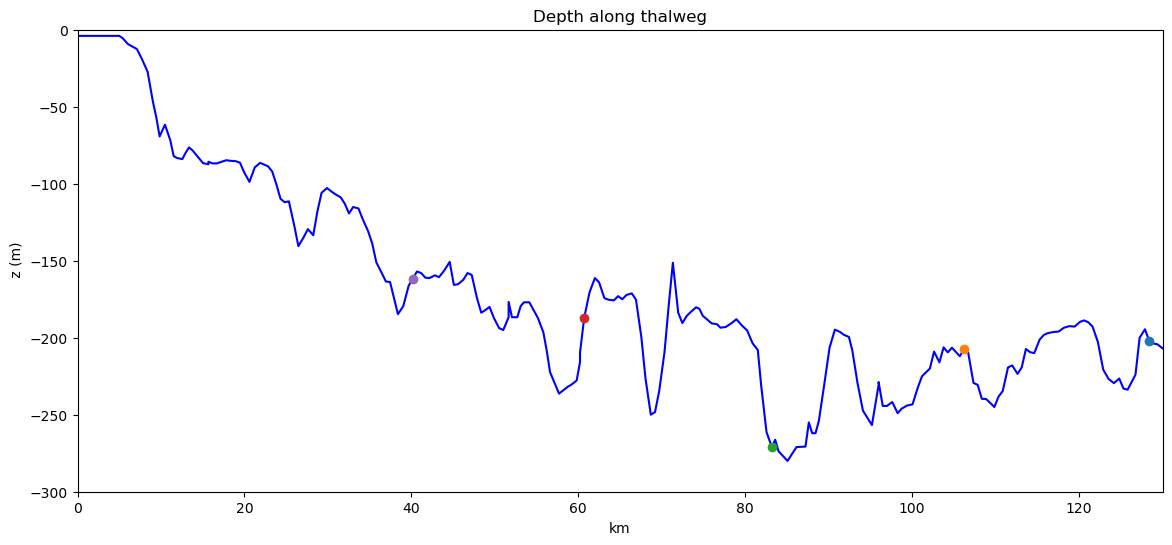

In [10]:
#look at the depths along the thalweg

depths = bathy[thalweg[:,0],thalweg[:,1]];
dx=400; dy=500
d = distance(thalweg,dx,dy,reverse=True); d=d/1000;

fig,ax = plt.subplots(1,1,figsize=(14,6))
ax.plot(d,-depths[:],color='b')
for k in range (1,6):
    pylab.plot(d[k*39], -depths[k*39],'o')

plt.ylim(-300,0)
plt.xlim(0,130)
ax.set_title('Depth along thalweg')
ax.set_xlabel('km')
ax.set_ylabel(' z (m)')

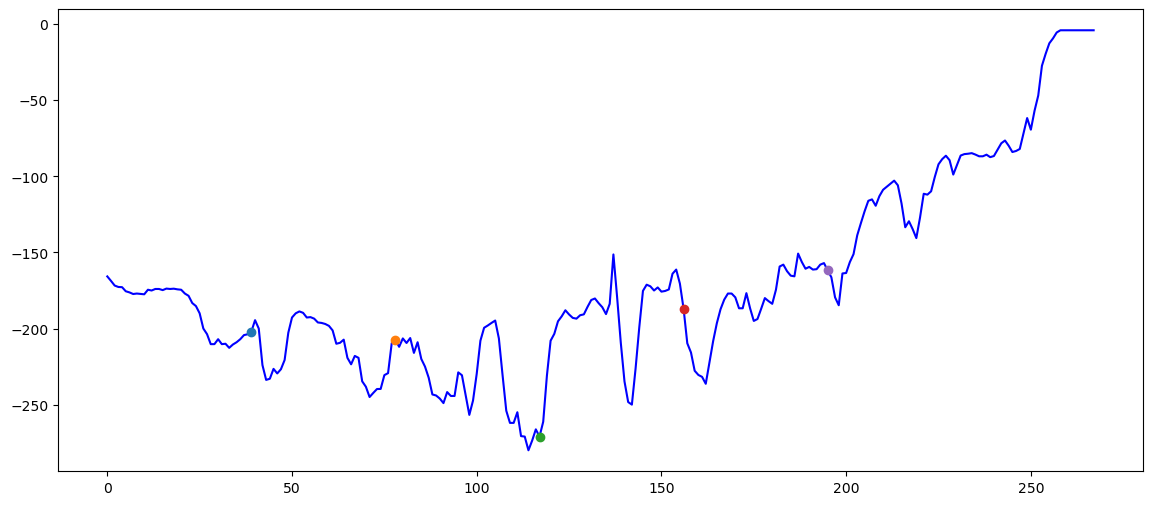

In [11]:
plt.figure(figsize=(14,6))
pylab.plot(-depths[:],color='b')
for k in range (1,6):
    pylab.plot(k*39, -depths[k*39],'o')